# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 4 K-Means Clustering ##

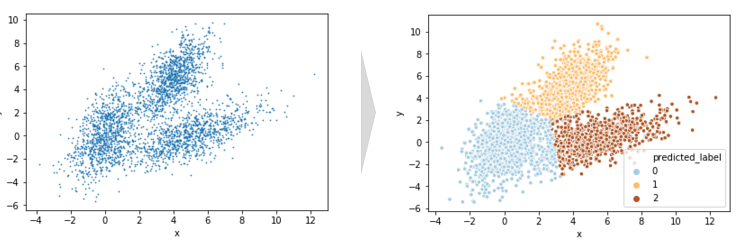

### Introduction

In this lab, we will implement **K-means clustering** on the **Iris dataset**, a widely used dataset containing three types of flowers, each represented by four features. K-means is a popular clustering algorithm that partitions data into $k$ clusters by iteratively assigning points to the nearest centroid and updating cluster centers.

![iris.png](attachment:f4bb498a-d534-44fc-8957-442795bb9af6.png)

## Import some packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

## Load Dataset

Our first step is to load the dataset and explore its structure before applying K-means clustering. The dataset consists of 150 samples, each with four features:
- Sepal Length
- Sepal Width
- Petal Length
- Petal Width

In [2]:
iris = datasets.load_iris()
X = iris.data
feature_names = iris.feature_names  # Get feature names

# Convert to DataFrame for better visualization
df = pd.DataFrame(X, columns=feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


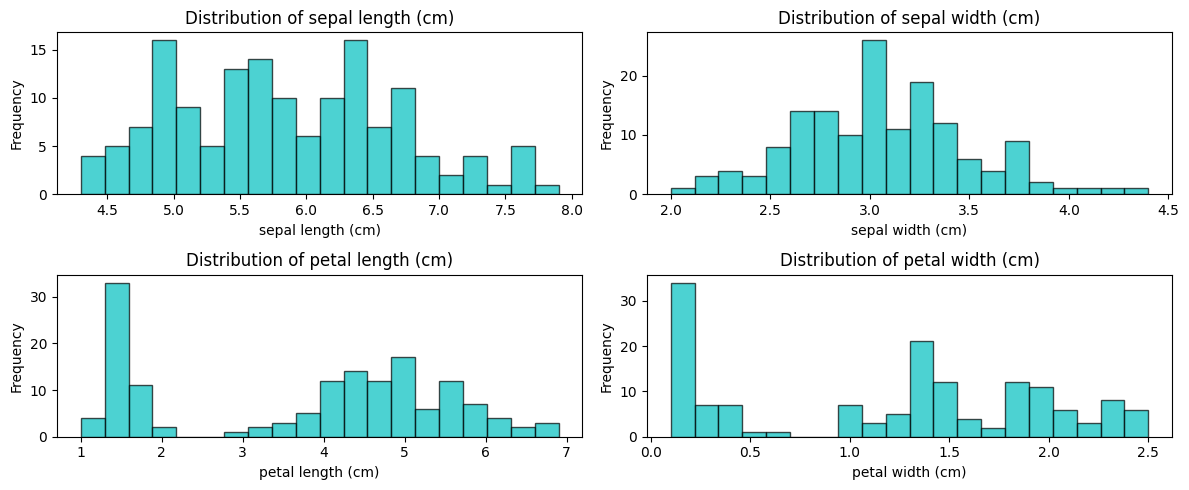

In [3]:
# Visualizing feature distributions
plt.figure(figsize=(12, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(X[:, i], bins=20, alpha=0.7, color='c', edgecolor='k')
    plt.title(f"Distribution of {feature_names[i]}")
    plt.xlabel(feature_names[i])
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Data Preprocessing
We define a simple data pre-processing function, `preprocess`, that
1. selects data from the Pandas DataFrame and stores it in a NumPy array;
2. applies log scaling to each indicator; and
3. scales all the values to be within the range from 0 to 1.

In [4]:
def preprocess_iris(df):
    """ Preprocesses only petal features (more relevant for clustering). """
    X = np.array(df)
    X_mins = X.min(axis=0)
    X_maxs = X.max(axis=0)
    X_scaled = (X - X_mins) / (X_maxs - X_mins)

    return X_scaled

# Apply preprocessing
X = preprocess_iris(df)
X

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

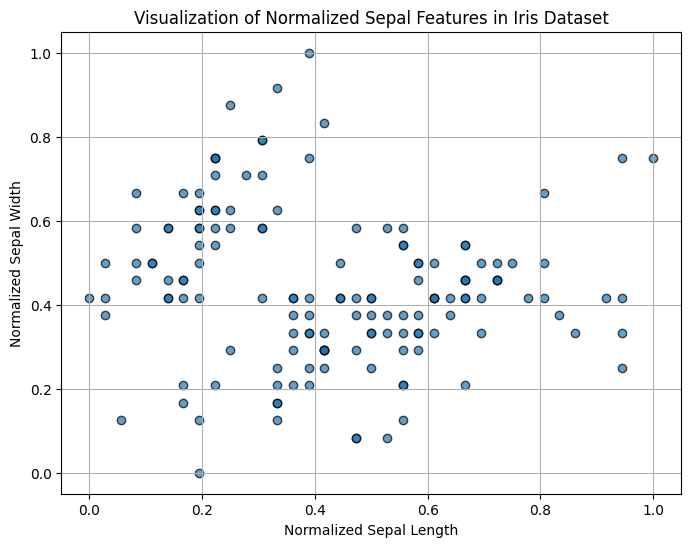

In [5]:
# Visualizing the normalized sepal features
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, edgecolors='k')
plt.xlabel("Normalized Sepal Length")
plt.ylabel("Normalized Sepal Width")
plt.title("Visualization of Normalized Sepal Features in Iris Dataset")
plt.grid(True)
plt.show()

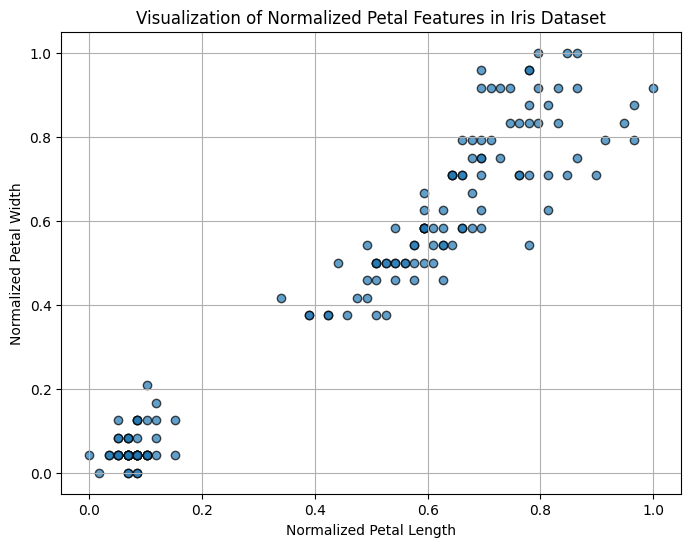

In [6]:
# Visualizing the normalized petal features
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 2], X[:, 3], alpha=0.7, edgecolors='k')
plt.xlabel("Normalized Petal Length")
plt.ylabel("Normalized Petal Width")
plt.title("Visualization of Normalized Petal Features in Iris Dataset")
plt.grid(True)
plt.show()

## **K-means++**

### **Background**

#### Importance of Proper Cluster Initialization
The initialization of cluster centers is crucial for the performance of K-means. A poor initialization can lead to:
- **Slow convergence**: The algorithm may take more iterations to stabilize.
- **Suboptimal clustering**: It may get stuck in local minima, resulting in poor clustering results.
- **Unstable results**: Different runs of the algorithm may produce significantly different clusters.

A common issue with K-means is that random initialization can result in unevenly distributed or redundant centroids, leading to poor clustering performance. To improve this, we will use **K-means++** initialization, which selects initial cluster centers in a way that maximizes their spread across the dataset. This method helps:
- Improve stability across different runs. ✅
- Speed up convergence. ✅
- Reduce the risk of poor clustering outcomes. ✅

### **K-means++ Clustering Steps**
#### K-means++ Initialization
1. Select the first centroid $x_0$ randomly from the dataset.
2. For each remaining $ k - 1 $ centroid:
   1. Compute the Euclidean distance of each data point to its nearest already chosen centroid:
     $$ D(x_i) = \min_{c \in C}{\sqrt{\sum_{j = 1}^d{(x_{ij} - c_i)}}} $$
     where $ C $ is the set of already chosen centroids.
   2. Assign a probability for each data point to be selected as the next centroid:
     $$ P(x_i) = \frac{D(x_i)^2}{\sum_j{D(x_j)^2}} $$
     where:
       - $ P(x_i) $ is the probability of selected data point.
       - $ D(x_i) $ is the shortest Euclidean distance from $ x_i $ to the nearest already chosen centroid.
       - $ \sum_j{D(x_j)^2} $ is the normalization factor ensuring probabilities sum to 1.
   3. Select the next centroid based on the probability.
3. Repeat until $k$ centroids are chosen.

#### Iteration Steps
- Assign Data Points
  - Calculate the distance from each data point to all cluster centroids.
  - Assign each data point to the nearest cluster centroid.
- Compute New Centroids
  - Update the position of each cluster centroid based on the current assignments.

#### Convergence Check
- Stop the algorithm based on the maximum number of iterations or other specified criteria.

## **Tasks**

### **Task 1: K-means++ Initialization**
Select $k$ cluster centroids using the K-means++ algorithm, ensuring they are well spread to improve convergence and clustering quality.

- Input:
    - $X$: Input data, a two-dimensional NumPy array where each row represents a data point and each column represents a feature.
    - $k$: The number of clusters, determining how many initial centroids need to be selected.

- Output:
    - A NumPy array of shape $(k,d)$, where $k$ is the number of clusters and $d$ is the number of features. Each row represents a selected initial centroid.

- Steps:
    1. Randomly select the first centroid from the dataset. (For simplification, please directly select the **first** point in the dataset)
    2. Compute the distance of each point to its nearest centroid.
    3. Select the next centroid with probability proportional to the squared distance. (For simplification, directly select the point that has the **largest distance** to its nearest centroid)
    4. Repeat the process until $k$ centroids are chosen.
    
- Remark:
    - Please use vectorization instead of loops to complete *TODO*.

In [7]:
def initialize_centroids_kmeans_pp(X, k):
    """
    Initializes k cluster centroids using a simplified max-min method.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        k (int): Number of clusters.

    Returns:
        centroids (ndarray): Initialized centroids of shape (k, n_features).
    """
    # TODO: Step 1: Select the first centroid
    centroids = np.full((k, X.shape[1]), 1e3)
    centroids[0] = X[0]
    distances = np.full((X.shape[0], k), 1e3)

    for cur_k in range(1, k):
        # TODO: Step 2: Compute distance of each point to the nearest centroid
        distances[:, cur_k-1] = np.sqrt(np.sum((X-centroids[cur_k-1])**2, axis=1))
        # TODO: Step 3: Choose the point with the max distance as the new centroid
        centroids[cur_k] = X[np.argmax(np.min(distances, axis=1))]

    return centroids

In [31]:
centroids = initialize_centroids_kmeans_pp(X, k := 3)
print(centroids.shape)
centroids

(3, 4)


array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.94444444, 0.25      , 1.        , 0.91666667],
       [0.16666667, 0.20833333, 0.59322034, 0.66666667]])

### Task 2: Assign Data Points to Clusters
Compute the Euclidean distance from each data point to all centroids and assign it to the nearest centroid.
- Input:
    - $X$: Input data, a two-dimensional NumPy array where each row represents a data point.
    - **centroids**: A NumPy array of shape $(k,d)$ containing the current cluster centroids.

- Output:
    - A one-dimensional NumPy array of length $n$, where $n$ is the number of data points. Each value represents the cluster index of the corresponding data point.

- Steps:
    1. Compute the Euclidean distance from each point to all centroids.
    2. Assign each point to the closest centroid.

- Remark:
    - Please use vectorization instead of loops to complete *TODO*.

In [27]:
def assign_clusters(X, centroids):
    """
    Assigns each data point to the nearest centroid.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        centroids (ndarray): Current centroids of shape (k, n_features).

    Returns:
        labels (ndarray): Cluster assignments for each data point.
    """
    # TODO: Compute the distance of each point to all centroids
    X = X[:, np.newaxis, :]
    centroids = centroids[np.newaxis]
    # print(X.shape)
    # print(centroids.shape)
    distances = np.sqrt(np.sum((X-centroids)**2, axis=2))
    # print(distances.shape)
    # distances.reshape((X.shape[0], centroids.shape[0]))

    # TODO: Assign each point to the closest centroid
    labels = np.argmin(distances, axis=1)

    return labels

In [28]:
labels = assign_clusters(X, centroids)
print(labels.shape)
labels

(150,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

### Task 3: Compute the New Centroids
Recalculate the cluster centroids based on the mean position of all data points assigned to each cluster.

- Input:
    - $X$: Input data, a two-dimensional NumPy array where each row represents a data point.
    - **labels**: A one-dimensional array indicating the cluster index of each data point.
    - $k$: The number of clusters.

- Output:
    - A NumPy array of shape $(k,d)$, where $k$ is the number of clusters and $d$ is the number of features. Each row represents the updated cluster centroid.

- Steps:
  1. For each cluster, compute the mean of all assigned data points.
  2. Update the cluster centroids accordingly.

- Remark:
    - You can only use one loop to complete the *TODO*.

In [29]:
def update_centroids(X, labels, k):
    """
    Updates cluster centroids based on the mean of assigned points.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        labels (ndarray): Cluster assignments for each data point.
        k (int): Number of clusters.

    Returns:
        new_centroids (ndarray): Updated centroids of shape (k, n_features).
    """
    # TODO: Compute new centroids as the mean of assigned data points
    new_centroids = np.zeros((k, X.shape[1]))
    for cur_k in range(k):
        new_centroids[cur_k] = X[labels == cur_k].mean(axis=0)

    return new_centroids

In [32]:
new_centroids = update_centroids(X, labels, k)
print(new_centroids.shape)
new_centroids

(3, 4)


array([[0.19611111, 0.595     , 0.07830508, 0.06083333],
       [0.72698413, 0.46071429, 0.80338983, 0.8297619 ],
       [0.44700855, 0.31089744, 0.58591917, 0.56346154]])

### Task 4: Complete K-Means Implementation

In [33]:
def k_means(X, k, max_iters=100, tol=1e-4):
    """
    Runs the K-means clustering algorithm.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        k (int): Number of clusters.
        max_iters (int): Maximum iterations.
        tol (float): Convergence tolerance.

    Returns:
        final_centroids (ndarray): Final cluster centroids.
        final_labels (ndarray): Final cluster assignments.
    """
    # Step 1: Initialize centroids using K-means++
    centroids = initialize_centroids_kmeans_pp(X, k)

    for _ in range(max_iters):
        # Step 2: Assign points to clusters
        labels = assign_clusters(X, centroids)

        # Step 3: Compute new centroids
        new_centroids = update_centroids(X, labels, k)

        # Step 4: Check for convergence (centroids do not change significantly)
        if np.linalg.norm(centroids - new_centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels

In [34]:
k = 3  # Number of clusters
final_centroids, final_labels = k_means(X, k)
final_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

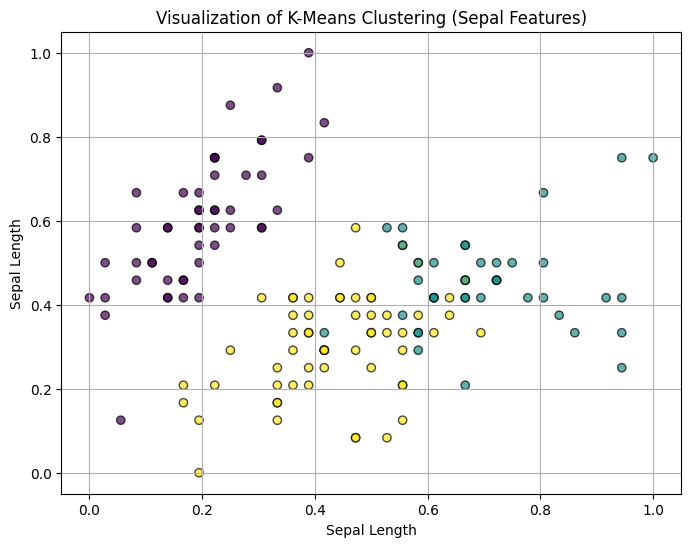

In [35]:
# Visualization of your results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Length")
plt.title("Visualization of K-Means Clustering (Sepal Features)")
# plt.legend()
plt.grid(True)
plt.show()

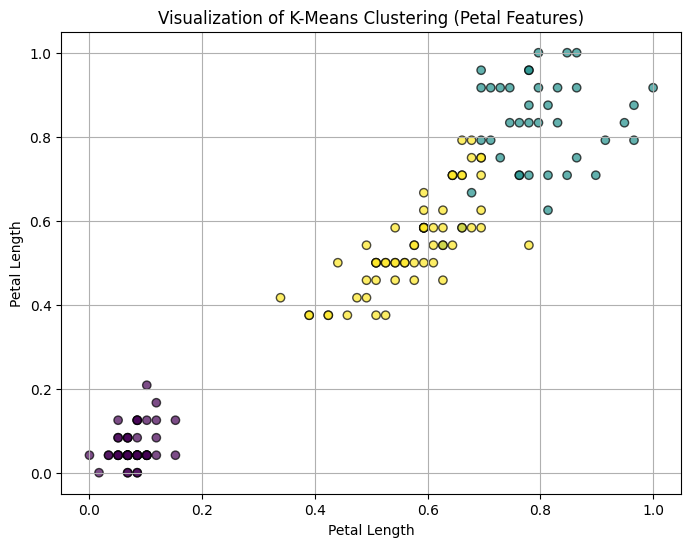

In [36]:
# Visualization of your results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 2], X[:, 3], c=final_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel("Petal Length")
plt.ylabel("Petal Length")
plt.title("Visualization of K-Means Clustering (Petal Features)")
# plt.legend()
plt.grid(True)
plt.show()